# Regressão Logística
## Qual  verdadeira média do curso de economia dado a participação 

* 1 - Estimar uma regressão de prticipação: fez ou não fez a prova. Resultara em um valor estimado que nada mais é que a probabilidade do aluno fazer a prova. O inverso desta probabilidade, utilizada como peso estatístico nas observações corrige-se o viés de seleção. Logit: calcular razões de chance e Probit: calcular o efeito marginal.
* 2 - Calibração da amostra para saber a verdadeira média do curso de economia.


In [426]:
library(dplyr)
library(ggplot2)
library(plyr)

In [401]:
data = read.table("dataset/enade.txt",sep=";", dec = ",", header = TRUE)
head(data)

,NU_ANO,CO_IES,CO_CATEGAD,CO_ORGACAD,CO_GRUPO,CO_CURSO,CO_MODALIDADE,CO_MUNIC_CURSO,CO_UF_CURSO,CO_REGIAO_CURSO,...,QE_I59,QE_I60,QE_I61,QE_I62,QE_I63,QE_I64,QE_I65,QE_I66,QE_I67,QE_I68
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,2018,1356,10003,10020,1,47116,1,3546603,35,3,...,6,6,6,6,6,6,6,6,6,5
2,2018,1356,10003,10020,1,47116,1,3546603,35,3,...,6,6,6,6,6,6,6,6,6,6
3,2018,1356,10003,10020,1,47116,1,3546603,35,3,...,6,6,6,6,6,6,6,6,6,5
4,2018,1356,10003,10020,1,47116,1,3546603,35,3,...,6,6,6,6,5,6,6,6,6,4
5,2018,1356,10003,10020,1,47116,1,3546603,35,3,...,6,6,6,6,6,6,6,6,6,6
6,2018,1356,10003,10020,1,47116,1,3546603,35,3,...,6,5,6,6,6,6,6,6,6,5


In [402]:
df = data[data$CO_GRUPO == 13 & data$TP_PRES==555,]

In [403]:
dim(df)

[1] 8075  137

In [404]:
df$ufpr = as.factor(ifelse(df$CO_IES == 571,1,0))

## Variáveis de IES

In [372]:
# Metodologia = QE_I29
# Ensino = QE_I38
# Coordenação = QE_I41
# Extensão = QE_I43
# Estrutura_salas = QE_I61 

In [405]:
df_1 = df %>% 
        select(NT_GER, CO_IES, ufpr, TP_SEXO, NU_IDADE,QE_I02, QE_I08, QE_I21, QE_I10,QE_I23,
              QE_I29, QE_I38, QE_I41, QE_I43, QE_I61) %>% 
        setNames(c("nota", "IES", "ufpr", "genero", "idade","cor", "renda", "escolaridade_pais","trabalho", "esforco",
                  "metodologia", "ensino", "coordenacao", "extensao", "estrutura"))

In [427]:
df_1$cor = mapvalues(df_1$cor, from=c("A","B","C","D","E","F"), to=c("branca","preta","amarela","parda","indigina","não declarado"))
df_1$renda = mapvalues(df_1$renda, from=c("A","B","C","D","E","F","G"), to=c("Até 1.5 salário mínimo","De 1.5 a 3 salários mínimos",
                                                                "De 3 a 4.5 salários mínimos","De 4.5 a 6 salários mínimos","De 6 a 10 salários mínimos",
                                                                                "10 a 30 salários mínimos", "Acima de 30 salários mínimos"))
df_1$escolaridade_pais = mapvalues(df_1$escolaridade_pais, from=c("A","B"), to=c("sim","não"))
df_1$trabalho = mapvalues(df_1$trabalho, from=c("A","B","C","D","E"), to=c("Não trabalha",
                                                                  "Trabalha eventualmente",
                                                                 "Trabalha até 20 hrs. semanais",
                                                                 "Trabalha de 21 a 39 hrs. semanais",
                                                                 "Trabalha 40 hrs. semanais ou mais"))
df_1$esforco = mapvalues(df_1$esforco, from=c("A","B","C","D","E"), to=c("Nenhuma, apenas assistindo as aulas","De uma a três",
                                                                "De quatro a sete","De oito adoze","Mais de doze"))

In [9]:
df_1$metodologia = as.factor(df_1$metodologia)
df_1$ensino = as.factor(df_1$ensino)
df_1$coordenacao = as.factor(df_1$coordenacao)
df_1$extensao = as.factor(df_1$extensao)
df_1$estrutura = as.factor(df_1$estrutura)

In [428]:
df_1$IES = as.factor(df_1$IES)

In [429]:
head(df_1)

,nota,IES,ufpr,genero,idade,cor,renda,escolaridade_pais,trabalho,esforco,metodologia,ensino,coordenacao,extensao,estrutura
,<dbl>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
161,24.9,1780,0,F,28,branca,De 3 a 4.5 salários mínimos,não,Trabalha 40 hrs. semanais ou mais,De quatro a sete,5,5,5,5,5
162,25.6,1780,0,M,30,branca,De 4.5 a 6 salários mínimos,sim,Trabalha 40 hrs. semanais ou mais,De uma a três,5,5,5,5,5
163,48.7,1780,0,M,29,branca,De 3 a 4.5 salários mínimos,não,Trabalha 40 hrs. semanais ou mais,De quatro a sete,5,5,5,5,5
164,35.7,1780,0,F,22,branca,De 1.5 a 3 salários mínimos,sim,Trabalha 40 hrs. semanais ou mais,De uma a três,5,5,5,5,5
165,33.9,1780,0,M,47,branca,De 1.5 a 3 salários mínimos,sim,Trabalha 40 hrs. semanais ou mais,De quatro a sete,5,5,5,5,5
166,23.5,1780,0,M,27,branca,De 3 a 4.5 salários mínimos,não,Trabalha 40 hrs. semanais ou mais,De quatro a sete,5,5,5,5,5


In [431]:
sapply(df_1, function(x) sum(is.na(x)))

nota               IES              ufpr            genero 
                4                 0                 0                 0 
            idade               cor             renda escolaridade_pais 
                0                 0                 0                 0 
         trabalho           esforco       metodologia            ensino 
                0                 0               101               128 
      coordenacao          extensao         estrutura 
              217               317               139

In [432]:
df_1 = df_1[!is.na(df_1$nota),]

In [433]:
dim(df_1)

[1] 8071   15

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message in max(ids, na.rm = TRUE):
"nenhum argumento não faltante para max; retornando -Inf"


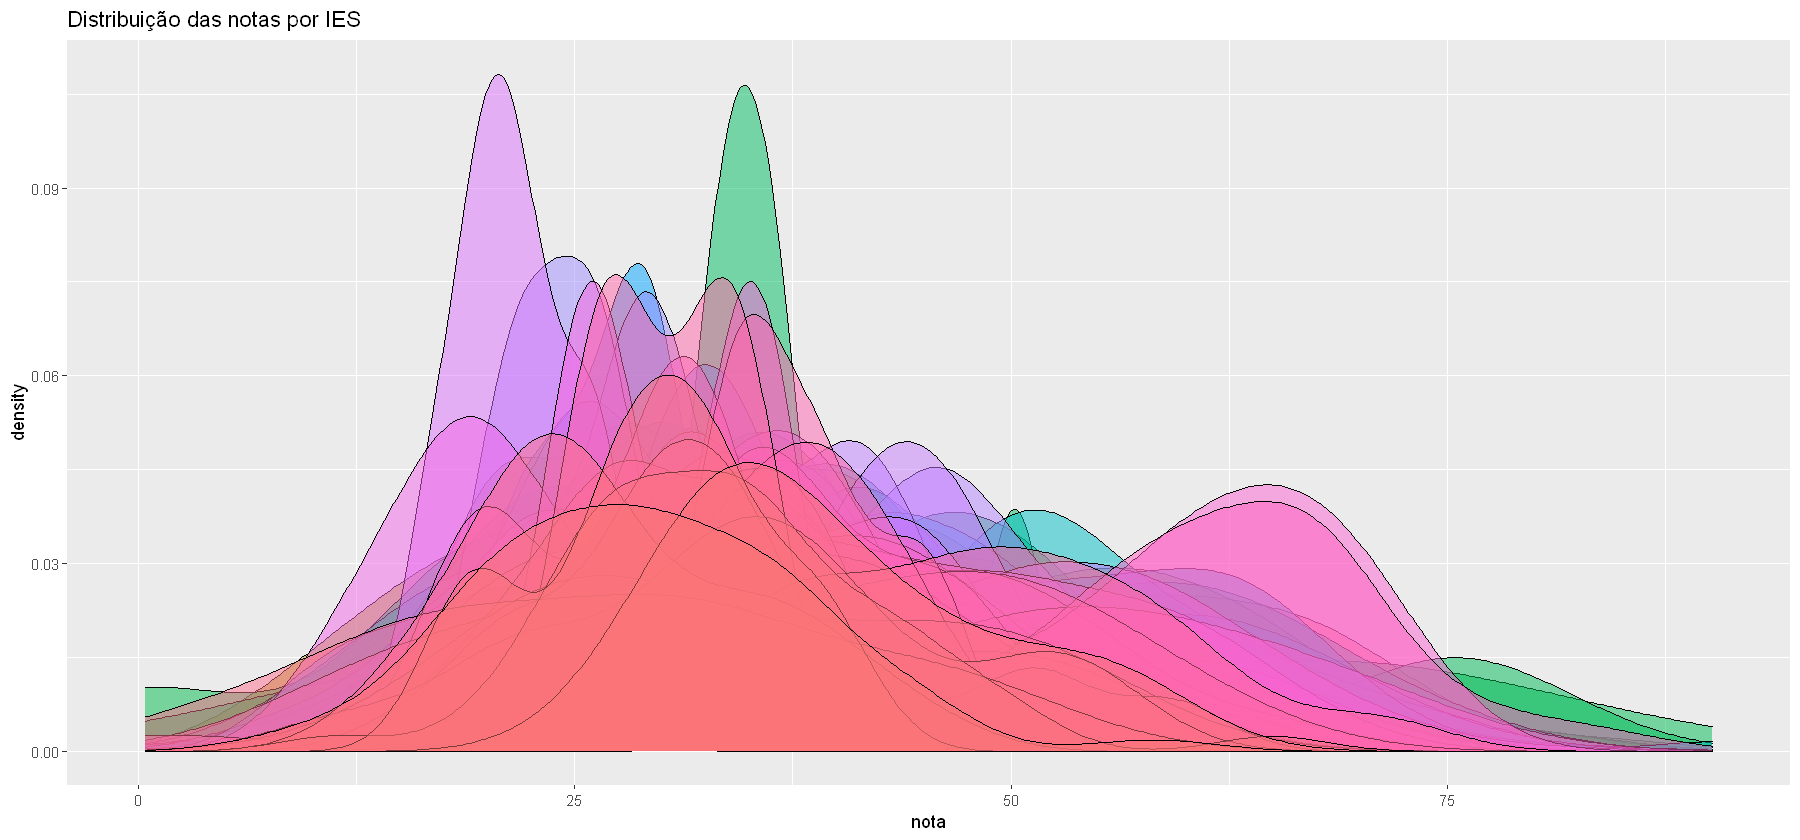

In [379]:
options(repr.plot.width = 15, repr.plot.height = 7)

df_1%>%subset(nota>0)%>% 
  ggplot(aes(x = nota)) +
  geom_density(aes(fill = IES),
               alpha = 0.5) + 
  ggtitle("Distribuição das notas por IES")+
  guides(fill=FALSE)

Picking joint bandwidth of 4.43



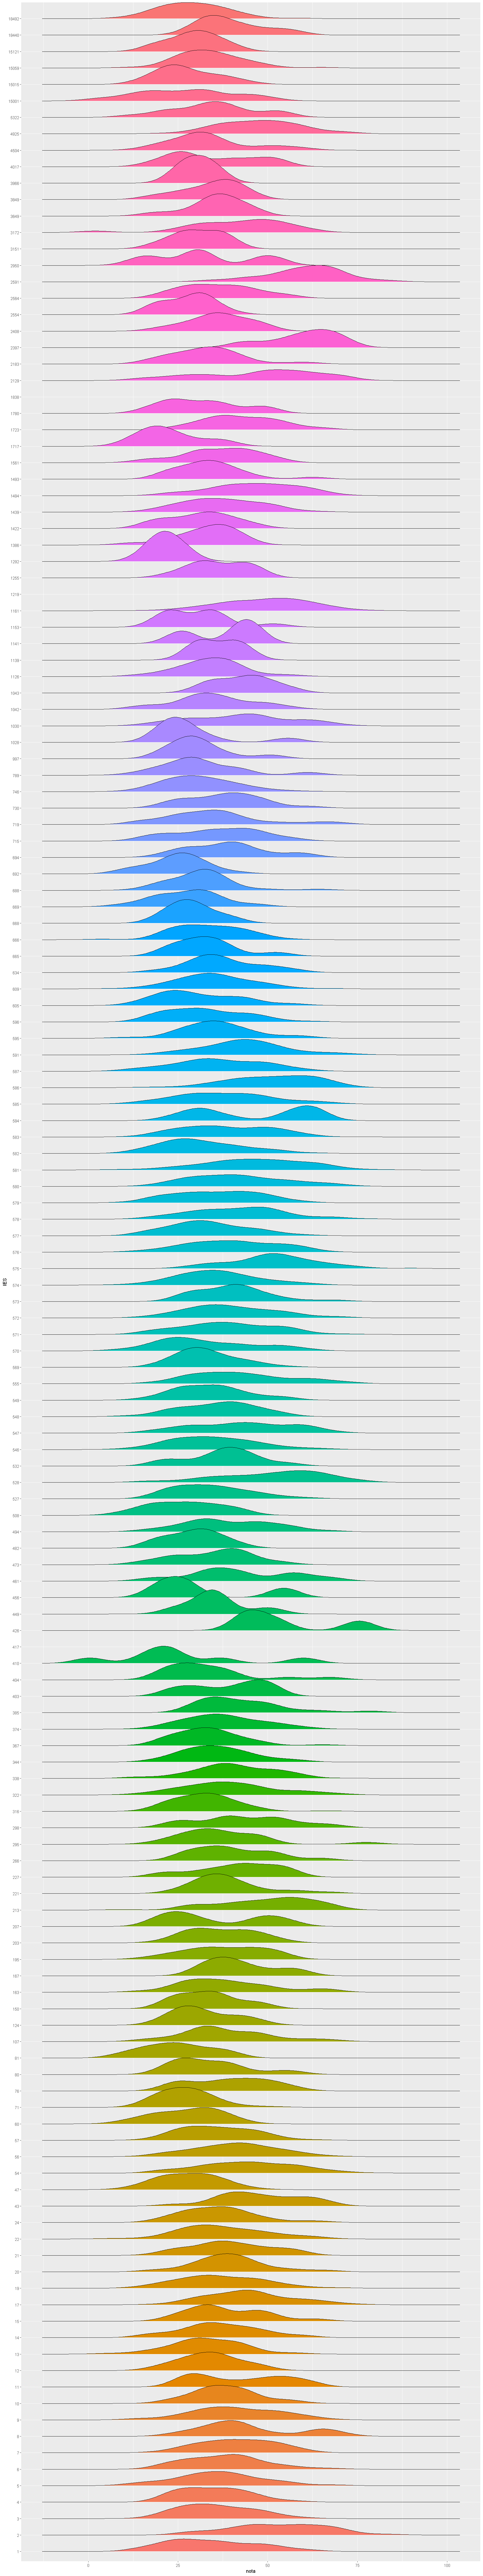

In [380]:
options(repr.plot.width = 15, repr.plot.height = 80)
df_1 %>%
  filter(nota > 0) %>% 
  ggplot(aes(y=IES,x = nota, fill = IES)) +
  geom_density_ridges(na.rm = TRUE, show.legend = FALSE)

In [434]:
rename = function(n){
    for(i in 1:6){
        df_1[n][df_1[n]==i] = i-1

    }
}

In [435]:
rename(11)

In [436]:
for(i in 1:6){
    df_1[11][df_1[11]==i] = i-1
    df_1[12][df_1[12]==i] = i-1
    df_1[13][df_1[13]==i] = i-1
    df_1[14][df_1[14]==i] = i-1
    df_1[15][df_1[15]==i] = i-1
}

In [437]:
table(df_1['metodologia'])
table(df_1['ensino'])
table(df_1['coordenacao'])
table(df_1['estrutura'])
table(df_1['extensao'])


   0    1    2    3    4 
 794  734 1303 1944 3195 


   0    1    2    3    4 
 853  841 1682 2161 2406 


   0    1    2    3    4 
1113  731 1202 1701 3107 


   0    1    2    3    4 
1034  743 1265 1806 3084 


   0    1    2    3    4 
 994  726 1198 1617 3219 

In [438]:
head(df_1)

,nota,IES,ufpr,genero,idade,cor,renda,escolaridade_pais,trabalho,esforco,metodologia,ensino,coordenacao,extensao,estrutura
,<dbl>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
161,24.9,1780,0,F,28,branca,De 3 a 4.5 salários mínimos,não,Trabalha 40 hrs. semanais ou mais,De quatro a sete,4,4,4,4,4
162,25.6,1780,0,M,30,branca,De 4.5 a 6 salários mínimos,sim,Trabalha 40 hrs. semanais ou mais,De uma a três,4,4,4,4,4
163,48.7,1780,0,M,29,branca,De 3 a 4.5 salários mínimos,não,Trabalha 40 hrs. semanais ou mais,De quatro a sete,4,4,4,4,4
164,35.7,1780,0,F,22,branca,De 1.5 a 3 salários mínimos,sim,Trabalha 40 hrs. semanais ou mais,De uma a três,4,4,4,4,4
165,33.9,1780,0,M,47,branca,De 1.5 a 3 salários mínimos,sim,Trabalha 40 hrs. semanais ou mais,De quatro a sete,4,4,4,4,4
166,23.5,1780,0,M,27,branca,De 3 a 4.5 salários mínimos,não,Trabalha 40 hrs. semanais ou mais,De quatro a sete,4,4,4,4,4


# Média das notas por IES

In [347]:
media_nota_IES = tapply(df_1$nota, df_1$IES, mean, na.rm=TRUE)
media_nota_IES

1          2          3          4          5          6          7 
34.5304348 53.0413043 35.8104478 35.0277778 36.3965116 38.1913793 41.5409639 
         8          9         10         11         12         13         14 
44.7733333 41.1018868 38.2105263 42.3764706 33.8741935 32.9400000 36.8562500 
        15         17         19         20         21         22         24 
38.8062500 44.1579710 37.1405594 39.4833333 39.6459016 37.6308824 36.5155172 
        43         47         54         56         57         60         71 
47.7351351 28.0541667 44.1073770 41.0596685 36.0691358 27.6375000 27.1478992 
        76         80         81        107        124        150        163 
39.4055556 34.2416667 24.7428571 38.4521127 32.2720000 33.4181818 37.6542857 
       167        195        197        203        207        213        221 
42.2818182 38.0166667        NaN 37.1802632 35.5200000 49.2174603 39.0160000 
       227        234        266        295        298        316        322 
41.4866667        NaN 40.6266667 37.6105263 43.6357143 32.6700000 39.5371429 
       338        344        367        374        385        403        404 
40.6268293 35.9923077 33.6473684 37.7450980 43.2590909 38.9600000 33.8600000 
       410        417        426        449        456        461        473 
25.6000000 44.4000000 54.2750000 35.6500000 31.6000000 42.6888889 34.8166667 
       482        494        496        508        527        528        532 
29.3851852 39.4633333        NaN 27.0066667 34.4641791 51.1772152 37.4333333 
       546        547        548        549        555        569        570 
34.9346801 43.1071429 36.1785714 34.1791667 42.7307692 33.1593220 33.0102564 
       571        572        573        574        575        576        577 
38.8061856 39.8782609 40.6035714 35.6080000 51.8847222 40.2962963 33.6211009 
       578        579        580        581        582        583        584 
42.1285714 35.8492754 41.9239837 46.6877551 31.8456790 38.8024194 45.7583333 
       585        586        587        591        595        596        605 
37.9058824 51.2389535 36.6064516 43.6024691 36.0368421 32.8647059 30.9735294 
       609        634        665        666        668        669        688 
35.0473684 37.5000000 33.0300000 32.8723077 28.8538462 27.7038462 30.7843750 
       692        694        715        719        730        746        789 
23.7695652 38.8125000 36.1225806 35.6952381 38.2050000 31.3462185 31.7423077 
       997       1028       1030       1042       1043       1126       1139 
30.9600000 28.5888889 42.5034188 34.8130435 43.1727273 34.1461538 36.2000000 
      1141       1153       1161       1219       1255       1292       1386 
38.0666667 30.6272727 49.1869281  0.4133333 36.3181818 21.5857143 33.0166667 
      1422       1439       1484       1493       1561       1717       1723 
31.3050000 37.4189873 46.4013699 34.2421053 36.5741935 22.7160000 42.6550000 
      1772       1780       1838       2129       2183       2397       2408 
       NaN 31.8454545 30.5500000 47.1945946 33.3186047 59.9642857 36.2692308 
      2554       2564       2591       2950       3151       3172       3649 
27.9187500 36.3000000 60.2815789 32.1000000 30.5142857 41.7440000 35.5181818 
      3849       3966       4017       4504       4925       5322      15001 
34.3187500 30.4000000 34.9200000 33.9193548 47.6394161 34.8823529 27.1791667 
     15015      15059      15121      18440      18492 
27.4178571 33.7716981 29.4652174 39.8000000 29.0783333

# Média das notas notas>0 por IES

# Mediana das notas por IES

In [281]:
# median_nota = tapply(df_1$nota, df_1$IES, median, na.rm=TRUE)
median_metodologia = tapply(df_1$metodologia, df_1$IES, median, na.rm=TRUE)


In [439]:
median_metodologia = tapply(df_1$metodologia, df_1$IES, median, na.rm=TRUE)
median_ensino = tapply(df_1$ensino, df_1$IES, median, na.rm=TRUE)
median_coordenacao = tapply(df_1$coordenacao, df_1$IES, median, na.rm=TRUE)
median_extensao = tapply(df_1$extensao, df_1$IES, median, na.rm=TRUE)
median_estrutura = tapply(df_1$estrutura, df_1$IES, median, na.rm=TRUE)

In [440]:
IES = as.factor(c(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,19,20,21,22,24,43,47,54,56,57,60,71,76,80,81,107,124,150,163,
167,195,197,203,207,213,221,227,234,266,295,298,316,322,338,344,367,374,385,403,404,410,417,426,449,456,
461,473,482,494,496,508,527,528,532,546,547,548,549,555,569,570,571,572,573,574,575,576,577,578,579,580,
581,582,583,584,585,586,587,591,595,596,605,609,634,665,666,668,669,688,692,694,715,719,730,746,789,997,
1028,1030,1042,1043,1126,1139,1141,1153,1161,1219,1255,1292,1386,1422,1439,1484,1493,1561,1717,1723,1772,
1780,1838,2129,2183,2397,2408,2554,2564,2591,2950,3151,3172,3649,3849,3966,4017,4504,4925,5322,15001,
15015,15059,15121, 18440, 18492))

In [441]:
df_2 <- data.frame(IES,median_metodologia,median_ensino, median_coordenacao, median_extensao,median_estrutura)

In [442]:
df = merge(df_1, df_2, all = T)
dim(df)

[1] 8075   20

In [443]:
head(df)

,IES,nota,ufpr,genero,idade,cor,renda,escolaridade_pais,trabalho,esforco,metodologia,ensino,coordenacao,extensao,estrutura,median_metodologia,median_ensino,median_coordenacao,median_extensao,median_estrutura
,<fct>,<dbl>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,22.7,0,F,26,amarela,De 1.5 a 3 salários mínimos,sim,Trabalha 40 hrs. semanais ou mais,"Nenhuma, apenas assistindo as aulas",4,2,4,2,3,3,3,4,2,4
2,1,61.3,0,M,23,branca,Até 1.5 salário mínimo,sim,Não trabalha,De quatro a sete,3,3,4,3,4,3,3,4,2,4
3,1,25.8,0,F,30,branca,De 1.5 a 3 salários mínimos,sim,Trabalha 40 hrs. semanais ou mais,De uma a três,2,2,3,1,1,3,3,4,2,4
4,1,47.9,0,M,22,preta,De 1.5 a 3 salários mínimos,sim,Não trabalha,De quatro a sete,4,4,4,4,4,3,3,4,2,4
5,1,36.6,0,F,23,branca,10 a 30 salários mínimos,sim,Trabalha de 21 a 39 hrs. semanais,De uma a três,2,1,2,1,4,3,3,4,2,4
6,1,24.6,0,F,24,branca,De 4.5 a 6 salários mínimos,sim,Trabalha de 21 a 39 hrs. semanais,De uma a três,3,3,3,4,4,3,3,4,2,4


Warning message:
"Removed 4 rows containing missing values (position_stack)."


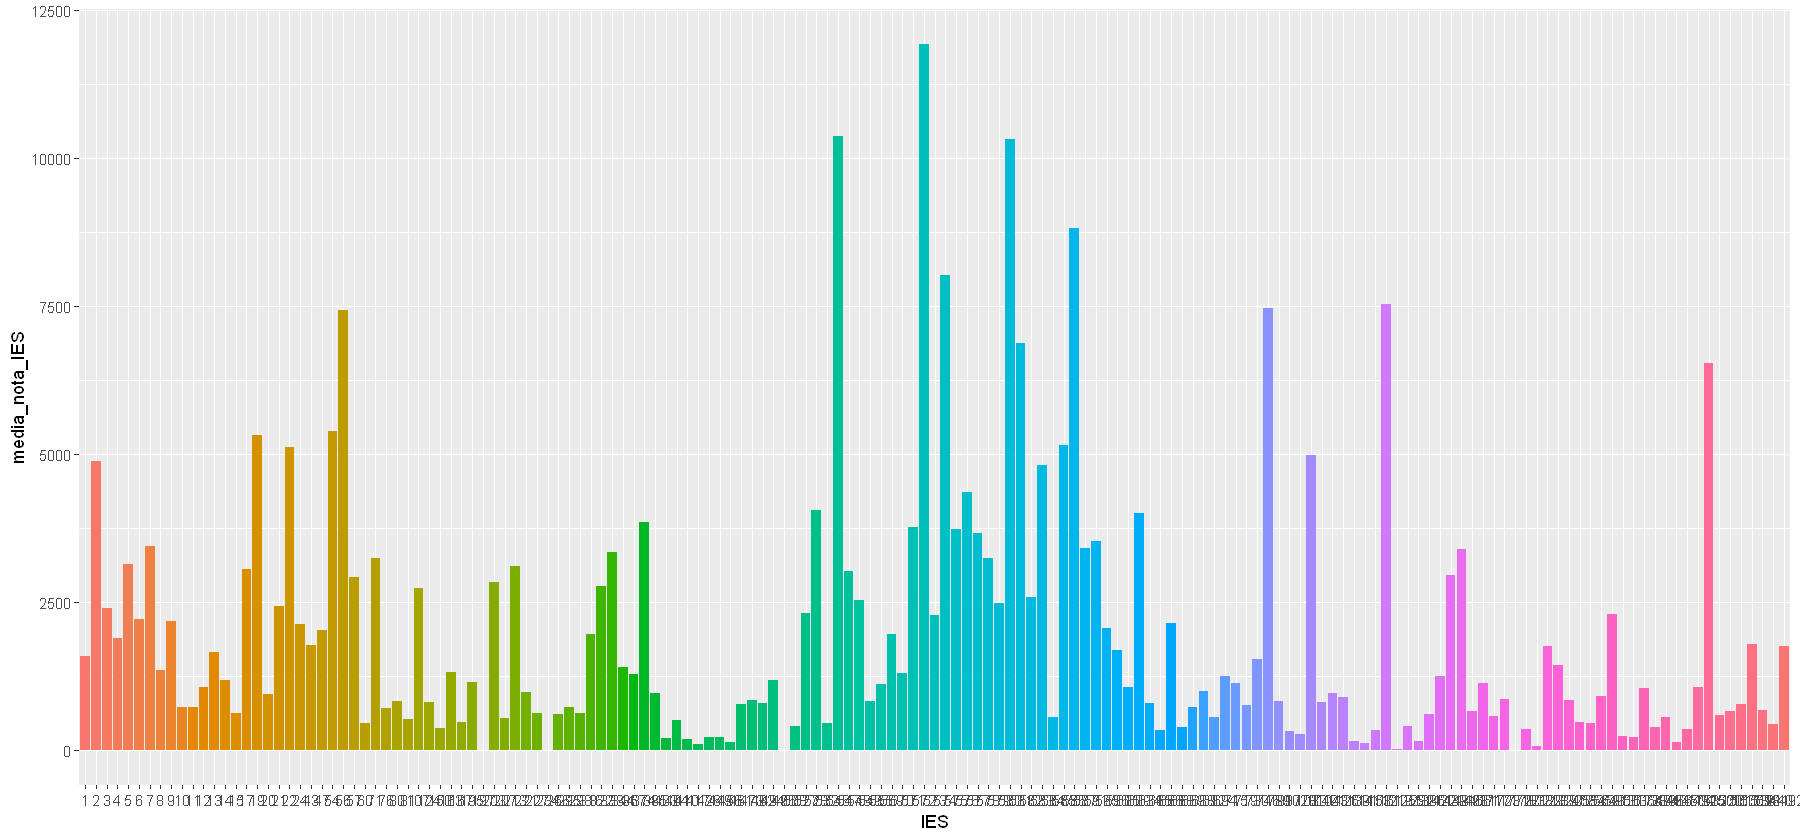

In [360]:
ggplot(df, aes(x = IES, y = media_nota_IES)) +
geom_bar(aes(fill = IES), stat = "identity") +
guides(fill=FALSE)

# Modelo_1

In [444]:
mod_1 = lm(nota~genero+cor+renda+trabalho+esforco+escolaridade_pais, data=df)
summary(mod_1)


Call:
lm(formula = nota ~ genero + cor + renda + trabalho + esforco + 
    escolaridade_pais, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-43.724  -8.344  -0.536   7.960  41.813 

Coefficients: (4 not defined because of singularities)
                                           Estimate Std. Error t value Pr(>|t|)
(Intercept)                                 31.7280     1.7303  18.337  < 2e-16
generoM                                      4.8795     0.2794  17.465  < 2e-16
corbranca                                    9.4945     1.8867   5.032 4.95e-07
corpreta                                     8.1148     1.9489   4.164 3.16e-05
coramarela                                   9.6412     2.0797   4.636 3.61e-06
corparda                                     8.8481     1.9057   4.643 3.49e-06
corindigina                                  2.4999     3.3614   0.744 0.457066
cornão declarado                            10.0222     2.0882   4.799 1.62e-06
rendaAté 1.5 salário mín

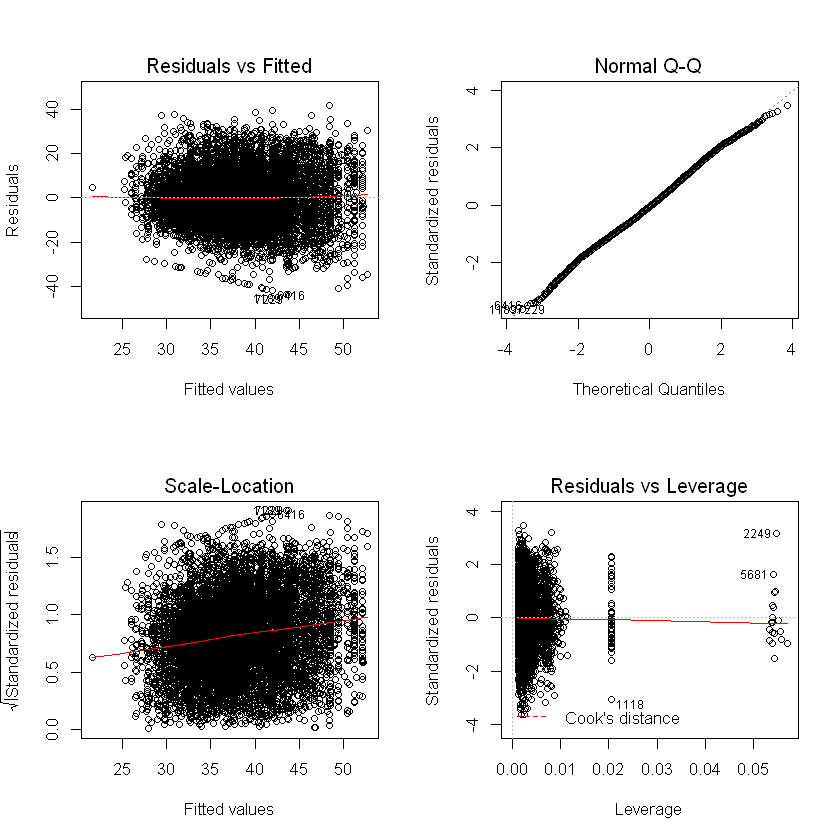

In [422]:
options(repr.plot.width = 7, repr.plot.height = 7)
par(mfrow=c(2,2))
plot(mod_1)

In [445]:
mod_2 = lm(nota~genero+cor+renda+trabalho+esforco+escolaridade_pais+median_metodologia+median_ensino+median_coordenacao+median_extensao+median_estrutura, data=df)
summary(mod_2)


Call:
lm(formula = nota ~ genero + cor + renda + trabalho + esforco + 
    escolaridade_pais + median_metodologia + median_ensino + 
    median_coordenacao + median_extensao + median_estrutura, 
    data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-44.947  -8.332  -0.472   7.881  40.163 

Coefficients: (4 not defined because of singularities)
                                           Estimate Std. Error t value Pr(>|t|)
(Intercept)                                 33.3561     1.8586  17.947  < 2e-16
generoM                                      4.8853     0.2790  17.512  < 2e-16
corbranca                                    9.7467     1.8853   5.170 2.40e-07
corpreta                                     8.4375     1.9465   4.335 1.48e-05
coramarela                                   9.8633     2.0766   4.750 2.07e-06
corparda                                     9.1434     1.9036   4.803 1.59e-06
corindigina                                  2.3302     3.3534   0.695 0.487155

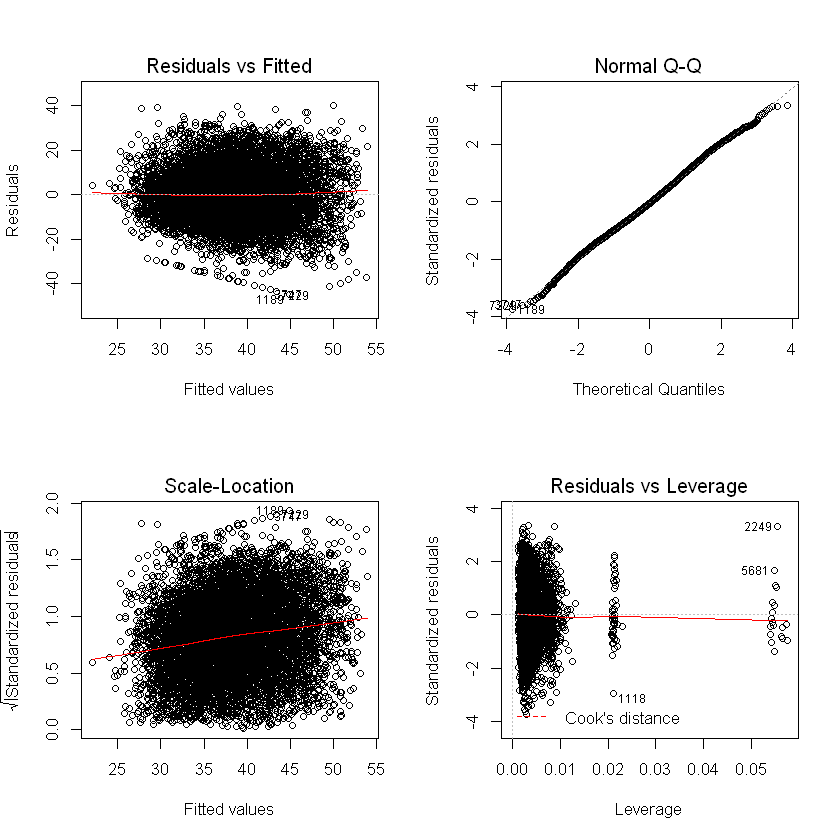

In [423]:
options(repr.plot.width = 7, repr.plot.height = 7)
par(mfrow=c(2,2))
plot(mod_2)